In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [4]:
warnings.filterwarnings('ignore')

## **Cargamos modelo**

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
            
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64,3)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [8]:
model = CNN()

In [9]:
model.load_state_dict(torch.load('Desktop/Ciencias_de_Datos/proyectos/plant_village/modelo_enfermades_papa.pth'))

<All keys matched successfully>

In [10]:
model.to('cpu')

CNN(
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14

In [11]:
val_transforms = transforms.Compose([
    transforms.Resize(256),           # Mismo resize
    transforms.CenterCrop(224),       # Crop central FIJO (no random)
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

In [16]:
idx

{0: 'Potato___Early_blight', 1: 'Potato___Late_blight', 2: 'Potato___healthy'}

## **Predicciones**

In [17]:
def predict(x, model,transforms, device='cpu'):
    """
    Predice la clase de una imagen y muestra visualización con probabilidades
    
    Args:
        x: ruta a la imagen
        model: modelo entrenado
        transforms: transformaciones de preprocesamiento
        idx: diccionario {indice: nombre_clase}
        device: 'cpu' o 'cuda'
    """
    
    # Cargar y preprocesar imagen
    img = Image.open(x).convert("RGB")
    x_tensor = val_transforms(img).unsqueeze(0).to(device)
    
    # Predicción
    model.eval()
    with torch.no_grad():
        outputs = model(x_tensor)
        probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()
    
    # Obtener predicción
    pred_idx = int(np.argmax(probs))
    pred_clase = idx[pred_idx]
    confidence = probs[pred_idx] * 100
    
    # Ordenar probabilidades de mayor a menor
    sorted_indices = np.argsort(probs)[::-1]
    sorted_probs = probs[sorted_indices]
    sorted_classes = [idx[i] for i in sorted_indices]
    
    # Crear figura con 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.2]})
    fig.patch.set_facecolor('white')
    
    # 📷 IZQUIERDA: Imagen original
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Imagen de Entrada', fontsize=14, fontweight='bold', pad=10)
    
    # Añadir recuadro con predicción principal
    ax1.text(0.5, -0.05, f'Predicción: {pred_clase}\nConfianza: {confidence:.2f}%', 
             transform=ax1.transAxes, ha='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#4CAF50', alpha=0.8, edgecolor='black'),
             color='white')
    
    # 📊 DERECHA: Gráfico de barras de probabilidades
    colors = ['#4CAF50' if i == pred_idx else '#CCCCCC' for i in sorted_indices]
    bars = ax2.barh(range(len(sorted_probs)), sorted_probs * 100, color=colors, edgecolor='black', linewidth=0.5)
    
    # Configurar ejes
    ax2.set_yticks(range(len(sorted_classes)))
    ax2.set_yticklabels([c.replace('___', ' ').replace('__', ' ') for c in sorted_classes], fontsize=10)
    ax2.set_xlabel('Probabilidad (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Distribución de Probabilidades', fontsize=14, fontweight='bold', pad=10)
    ax2.set_xlim(0, 100)
    
    # Añadir valores en las barras
    for i, (bar, prob) in enumerate(zip(bars, sorted_probs)):
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{prob*100:.2f}%', ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Invertir eje Y para que la mayor probabilidad esté arriba
    ax2.invert_yaxis()
    
    # Grid horizontal
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()
    
    return pred_clase, confidence

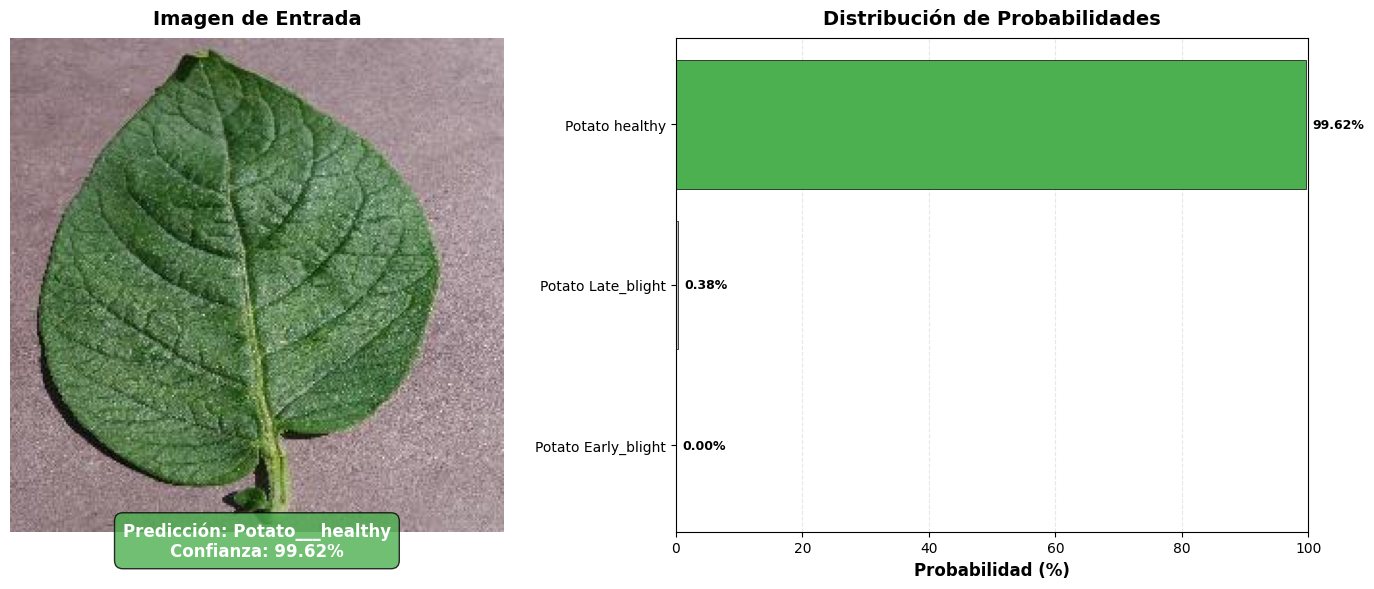

Resultado: Potato___healthy (99.62%)


In [18]:


# Llamar a la función
ruta_imagen = r"C:\Users\Chucho\Downloads\potato_healthy.JPG"
prediccion, confianza = predict(
    x=ruta_imagen,
    model=model,
    transforms=val_transforms,
    device='cpu'
)

print(f"Resultado: {prediccion} ({confianza:.2f}%)")

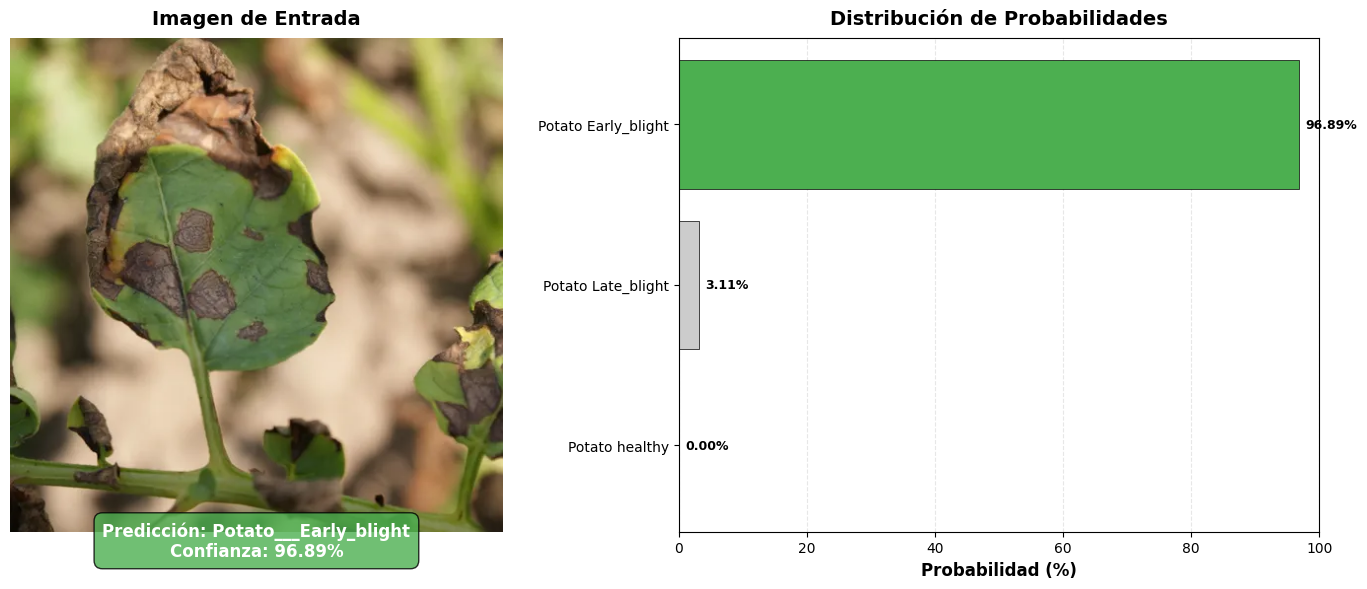

Resultado: Potato___Early_blight (96.89%)


In [19]:

# Llamar a la función
ruta_imagen = r"C:\Users\Chucho\Downloads\ca2020_early_blight_potato_damage2.webp"
prediccion, confianza = predict(
    x=ruta_imagen,
    model=model,
    transforms=val_transforms,
    device='cpu'
)

print(f"Resultado: {prediccion} ({confianza:.2f}%)")

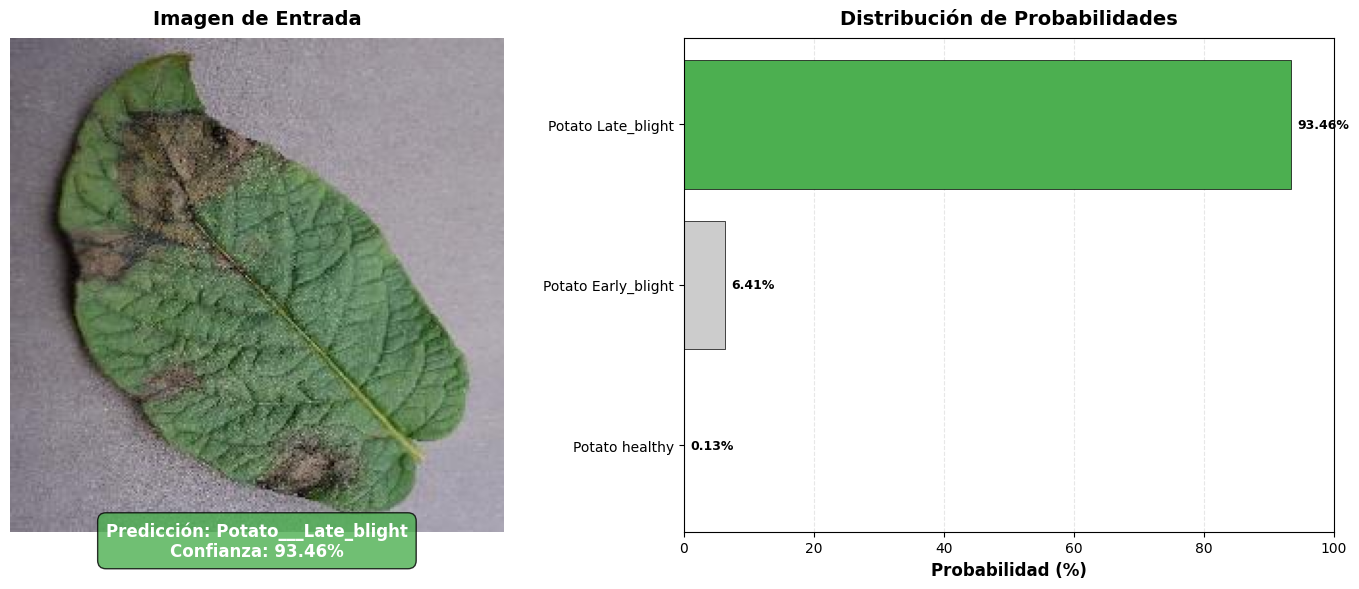

Resultado: Potato___Late_blight (93.46%)


In [20]:
ruta_imagen = r"C:/Users/Chucho/Downloads/potato_leat_blight.JPG"
prediccion, confianza = predict(
    x=ruta_imagen,
    model=model,
    transforms=val_transforms,
    device='cpu'
)

print(f"Resultado: {prediccion} ({confianza:.2f}%)")

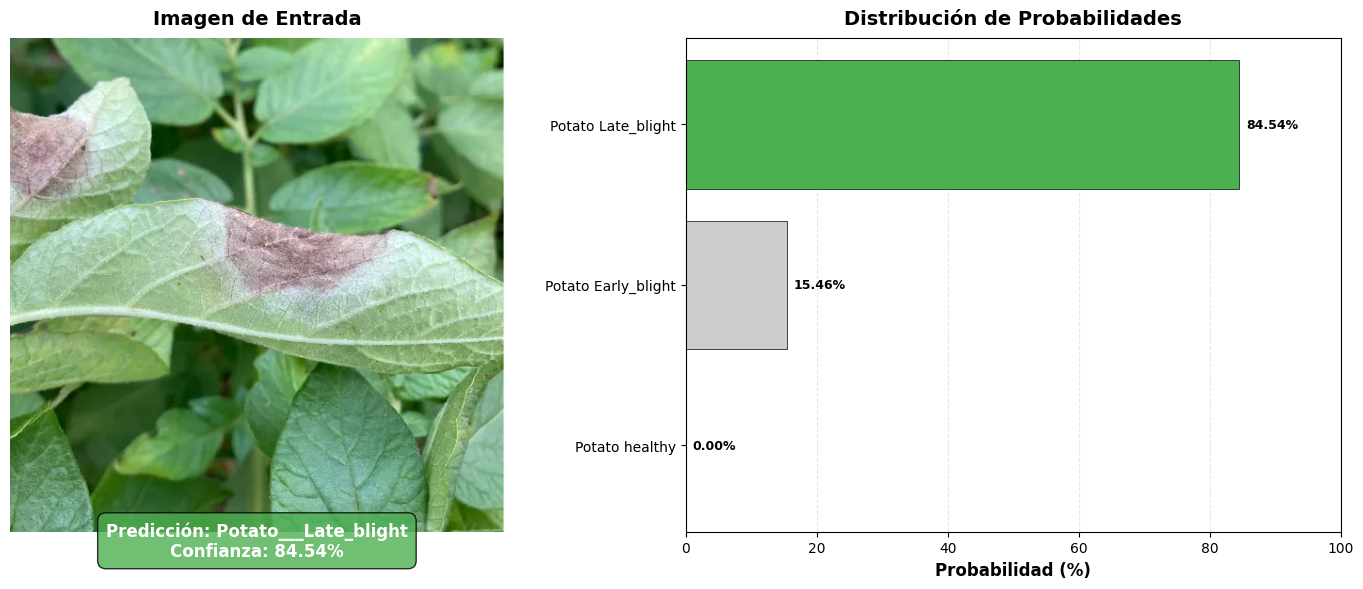

Resultado: Potato___Late_blight (84.54%)


In [21]:
ruta_imagen = r"C:\Users\Chucho\Downloads\ca2024_potato_late_blight.webp"
prediccion, confianza = predict(
    x=ruta_imagen,
    model=model,
    transforms=val_transforms,
    device='cpu'
)

print(f"Resultado: {prediccion} ({confianza:.2f}%)")

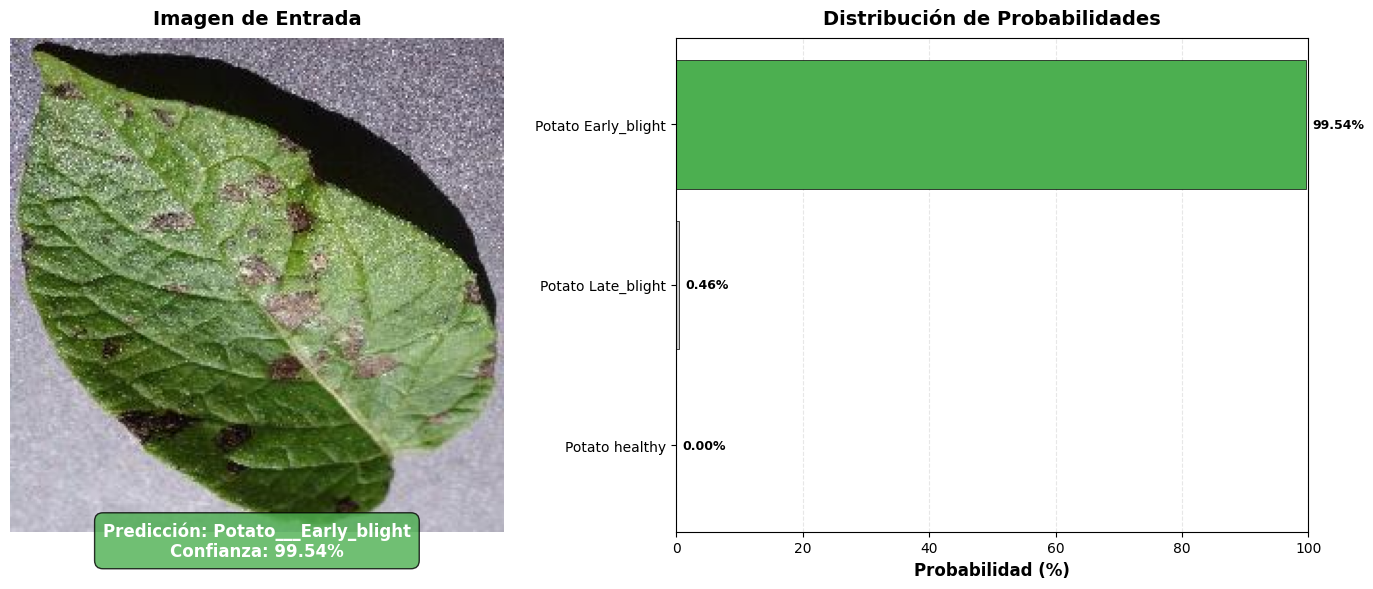

Resultado: Potato___Early_blight (99.54%)


In [22]:
ruta_imagen = r"C:/Users/Chucho/Downloads/potato_early_blight.JPG"
prediccion, confianza = predict(
    x=ruta_imagen,
    model=model,
    transforms=val_transforms,
    device='cpu'
)

print(f"Resultado: {prediccion} ({confianza:.2f}%)")